# Data Science for Business - Convolutional Neural Network (CNN) on Fashion MNIST

## Initialize notebook
Load required packages and set up workspace, e.g., initialize the random number generator.

In [4]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 13.8 MB/s eta 0:00:00


In [5]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
from torchmetrics import Accuracy

In [6]:
torch.manual_seed(42)

Check if we are using the GPU.

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Problem description

The Fashion MNIST dataset is a dataset of thumbnails of fashion articles from Zalando (28x28 grayscale images). The dataset consists of a training set of 60,000 examples and a test set of 10,000 examples. Each image is associated with a label from 10 classes (e.g., Shirts, Sneakers, Trousers...). The dataset is balanced in terms of label distribution.

You can have a look at the dataset here: https://github.com/zalandoresearch/fashion-mnist

Your task is to train a CNN classifier to predict the class of the fashion articles.

## Load data

The dataset is built into the Pytorch library, so we can load it directly.

In [8]:
batch_size = 64

We can perform a number of transformations during loading. For now, we only convert the images to Pytorch tensors.

In [9]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [10]:
train_dataset = datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root="./data", train=False, transform=transform, download=True)

100%|██████████| 26.4M/26.4M [00:01<00:00, 16.9MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 272kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.09MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 17.8MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [14]:
#Training loader can load data on the fly
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Let's check the dimensions of the training and test sets.

In [12]:
print(train_loader.dataset.data.shape)
print(test_loader.dataset.data.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


Take a look at the first image in the training set.

In [13]:
train_loader.dataset.data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,
           0,  13,  73,   0,   0,   1,   4,   0,   0,   0,   0,   1,   1,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,   0,
          36, 136, 127,  62,  54,   0,   0,   0,   1,   3,   4,   0,   0,   3],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6,   0,
         102, 204, 176, 134, 144, 123,  23,   0,   0,   0,   0,  12,  10,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

We can take this tensor of integers and pass it to the `imshow()` function of `matplotlib` to visualize the image. Looks like a sneaker! From Nike?

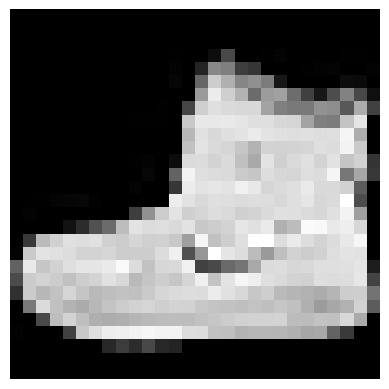

In [15]:
plt.imshow(train_loader.dataset.data[0], cmap='gray')
plt.axis('off')
plt.show()

What is the label of this image?

In [16]:
print("Label:", train_loader.dataset.targets[0])
print("List of labels:", train_loader.dataset.classes)


Label: tensor(9)
List of labels: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


## Network architecture

Like with MLPs, we define the architecture of a CNN by creating a class that inherits form the `torch.nn.Module`.

Our simple CNN has the following architecture:
- Convolutional layer with 16 filters of size 3x3 (kernel) with a stride of 1 and padding of 1.
- ReLU activation function.
- Max pooling layer with a kernel size of 2x2 and stride of 2.
- A layer without parameters that flattens the input.
- Fully connected layer with 128 units.
- ReLU activation function.
- Fully connected layer with 10 units (one for each class).

In [17]:
# Define CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 14 * 14, 128) # 16 out_channels of the convolution, 14x14 image dimension after pooling with kernel_size=2 --> flatten the image (making one dimensional)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Let's initialize the CNN class and specify an optimizer and loss function. `CrossEntropyLoss` is a common loss function for multi-class classification problems.

In [18]:
learning_rate = 0.001
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [19]:
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Linear-4                  [-1, 128]         401,536
              ReLU-5                  [-1, 128]               0
            Linear-6                   [-1, 10]           1,290
Total params: 402,986
Trainable params: 402,986
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.22
Params size (MB): 1.54
Estimated Total Size (MB): 1.76
----------------------------------------------------------------


# Train the network

The training loop is similar to the one for MLPs. We iterate over the training set, make predictions, calculate the loss, and update the weights of the network.

In [20]:
num_epochs = 5

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/5], Loss: 0.4753
Epoch [2/5], Loss: 0.3075
Epoch [3/5], Loss: 0.2640
Epoch [4/5], Loss: 0.2347
Epoch [5/5], Loss: 0.2124


## Make predictions

Finally, we make predictions on the test set and calculate the accuracy of the model. Don't forget to set the model to evaluation mode before making predictions.

In [21]:
model.eval()
accuracy_metric = Accuracy(task="multiclass", num_classes=10).to(device)
accuracy_metric.reset()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)  # Apply softmax to get probabilities
        accuracy_metric.update(probabilities, labels)

test_accuracy = accuracy_metric.compute()
print(f"Test Accuracy: {test_accuracy.item():.2f}")

Test Accuracy: 0.90


We can also compute predictions for an individual image. Let's take the first image of the training set (the Nike sneaker) and see what the model predicts.

In [22]:
logits = model(train_loader.dataset.data[0].unsqueeze(0).unsqueeze(0).float().to(device))
probs = torch.softmax(logits, dim=1)
pred = torch.argmax(probs, dim=1)
pred_label = train_loader.dataset.classes[pred]
print(probs)
print(f"Predicted label: {pred_label}")

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], grad_fn=<SoftmaxBackward0>)
Predicted label: Ankle boot
